<a href="https://colab.research.google.com/github/FZsara/image_processing/blob/main/ip_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

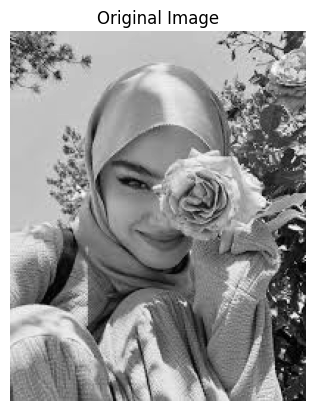

Huffman Encoded Data: 0101011011110000001101111110010010110100001101100010011011100011111010000001111110011010000001101101...


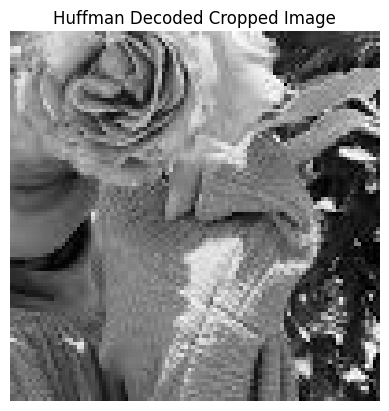

Arithmetic Encoded Value: 0.36352667810495326


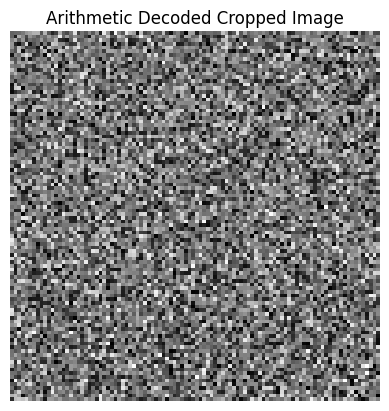

RLE Encoded Data: [(99, 1), (106, 1), (107, 1), (122, 1), (150, 1), (162, 1), (177, 1), (183, 1), (191, 1), (201, 1)]...


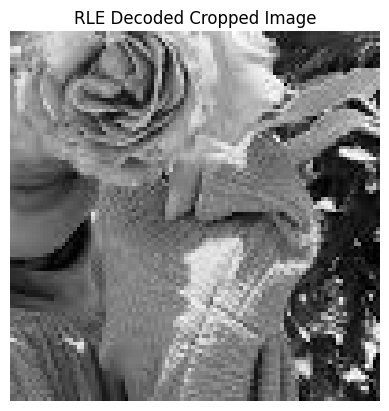

LZW Encoded Data: [99, 106, 107, 122, 150, 162, 177, 183, 191, 201]...


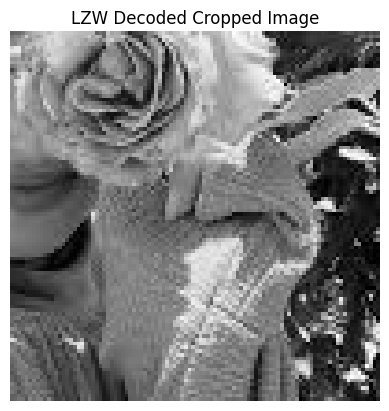

Block Encoded Data: [array([[ 99, 106, 107, 122, 150, 162, 177, 183],
       [119, 133, 130, 152, 202, 160, 171, 159],
       [132, 140, 152, 167, 152, 141, 173, 186],
       [136, 133, 160, 164, 159, 177, 186, 200],
       [203, 231, 231, 150, 187, 188, 154, 195],
       [225, 229, 231, 156, 169, 155, 149, 172],
       [186, 182, 188, 126, 148, 148, 166, 159],
       [146, 145, 156, 131, 158, 125, 189, 181]], dtype=uint8), array([[191, 201, 187, 201, 218, 210, 202, 201],
       [173, 203, 214, 214, 220, 210, 200, 197],
       [193, 203, 216, 201, 217, 213, 203, 189],
       [196, 193, 216, 203, 212, 216, 206, 181],
       [172, 199, 213, 211, 207, 200, 192, 186],
       [158, 195, 203, 209, 200, 199, 197, 191],
       [169, 193, 179, 206, 204, 202, 196, 187],
       [145, 177, 215, 208, 212, 202, 187, 173]], dtype=uint8)]...


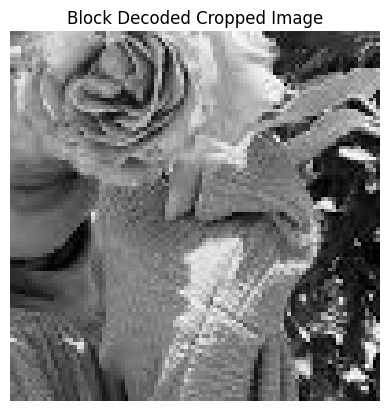

In [5]:
import numpy as np
import heapq
import collections
from itertools import groupby
from PIL import Image
import matplotlib.pyplot as plt

# Helper function to show an image
def show_image(img, title='Image'):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load the image using PIL and convert to grayscale
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # 'L' mode is grayscale
    return np.array(image)

# Huffman Coding
class HuffmanCoding:
    def __init__(self, image):  # Corrected __init__ method
        self.image = image
        self.frequency = self.calculate_frequency(image)
        self.codes = self.build_huffman_tree()

    def calculate_frequency(self, image):
        pixels = image.flatten()
        frequency = collections.Counter(pixels)
        return frequency

    def build_huffman_tree(self):
        heap = [[weight, [symbol, ""]] for symbol, weight in self.frequency.items()]
        heapq.heapify(heap)

        while len(heap) > 1:
            lo = heapq.heappop(heap)
            hi = heapq.heappop(heap)

            for pair in lo[1:]:
                pair[1] = '0' + pair[1]
            for pair in hi[1:]:
                pair[1] = '1' + pair[1]

            heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

        huffman_tree = heap[0]
        return {symbol: code for symbol, code in huffman_tree[1:]}

    def encode(self):
        encoded_image = ''.join([self.codes[pixel] for pixel in self.image.flatten()])
        return encoded_image

    def decode(self, encoded_image):
        reverse_codes = {v: k for k, v in self.codes.items()}
        current_code = ''
        decoded_pixels = []

        for bit in encoded_image:
            current_code += bit
            if current_code in reverse_codes:
                decoded_pixels.append(reverse_codes[current_code])
                current_code = ''

        return np.array(decoded_pixels).reshape(self.image.shape)

# Arithmetic Coding
class ArithmeticCoding:
    def __init__(self, image):  # Corrected __init__ method
        self.image = image
        self.frequency = self.calculate_frequency(image)
        self.cumulative_probabilities = self.build_cumulative_probabilities()

    def calculate_frequency(self, image):
        pixels = image.flatten()
        frequency = collections.Counter(pixels)
        total_pixels = len(pixels)
        return {k: v / total_pixels for k, v in frequency.items()}

    def build_cumulative_probabilities(self):
        cumulative_probabilities = {}
        cumulative_prob = 0
        for pixel, prob in sorted(self.frequency.items()):
            cumulative_probabilities[pixel] = (cumulative_prob, cumulative_prob + prob)
            cumulative_prob += prob
        return cumulative_probabilities

    def encode(self):
        low, high = 0.0, 1.0
        for pixel in self.image.flatten():
            range = high - low
            low, high = low + range * self.cumulative_probabilities[pixel][0], low + range * self.cumulative_probabilities[pixel][1]
        return (low + high) / 2

    def decode(self, encoded_value, length):
        decoded_pixels = []
        for _ in range(length):
            for pixel, (low, high) in self.cumulative_probabilities.items():
                if low <= encoded_value < high:
                    decoded_pixels.append(pixel)
                    encoded_value = (encoded_value - low) / (high - low)
                    break
        return np.array(decoded_pixels).reshape(self.image.shape)

# Run-Length Encoding (RLE)
def rle_encode(image):
    flattened = image.flatten()
    rle = [(key, len(list(group))) for key, group in groupby(flattened)]
    return rle

def rle_decode(rle, shape):
    flattened = [pixel for pixel, length in rle for _ in range(length)]
    return np.array(flattened).reshape(shape)

# Lempel-Ziv-Welch (LZW) Coding
def lzw_encode(image):
    pixels = image.flatten()
    dictionary = {chr(i): i for i in range(256)}
    w = chr(pixels[0])
    encoded = []

    for pixel in pixels[1:]:
        wc = w + chr(pixel)
        if wc in dictionary:
            w = wc
        else:
            encoded.append(dictionary[w])
            dictionary[wc] = len(dictionary)
            w = chr(pixel)
    if w:
        encoded.append(dictionary[w])
    return encoded

def lzw_decode(encoded_image, image_shape):
    dictionary = {i: chr(i) for i in range(256)}
    w = chr(encoded_image.pop(0))
    decoded = [w]

    for k in encoded_image:
        if k in dictionary:
            entry = dictionary[k]
        elif k == len(dictionary):
            entry = w + w[0]
        decoded.append(entry)
        dictionary[len(dictionary)] = w + entry[0]
        w = entry

    decoded_pixels = [ord(c) for entry in decoded for c in entry]
    return np.array(decoded_pixels).reshape(image_shape)

# Block Coding
def block_encode(image, block_size=8):
    height, width = image.shape
    blocks = []
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i+block_size, j:j+block_size]
            blocks.append(block)
    return blocks

def block_decode(blocks, image_shape, block_size=8):
    height, width = image_shape
    reconstructed_image = np.zeros(image_shape, dtype=np.uint8)
    idx = 0
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = blocks[idx]
            reconstructed_image[i:i+block_size, j:j+block_size] = block
            idx += 1
    return reconstructed_image

# Main
image_path = '/content/drive/MyDrive/hijabi.jpg'
image = load_image(image_path)
show_image(image, "Original Image")

cropped_image = image[100:200, 100:200]

# Huffman Coding
huffman = HuffmanCoding(cropped_image)
encoded_huffman = huffman.encode()
print(f"Huffman Encoded Data: {encoded_huffman[:100]}...")
decoded_huffman = huffman.decode(encoded_huffman)
show_image(decoded_huffman, "Huffman Decoded Cropped Image")

# Arithmetic Coding
arithmetic = ArithmeticCoding(cropped_image)
encoded_arithmetic = arithmetic.encode()
print(f"Arithmetic Encoded Value: {encoded_arithmetic}")
decoded_arithmetic = arithmetic.decode(encoded_arithmetic, cropped_image.size)
show_image(decoded_arithmetic, "Arithmetic Decoded Cropped Image")

# RLE Encoding
rle = rle_encode(cropped_image)
print(f"RLE Encoded Data: {rle[:10]}...")
decoded_rle = rle_decode(rle, cropped_image.shape)
show_image(decoded_rle, "RLE Decoded Cropped Image")

# LZW Encoding
encoded_lzw = lzw_encode(cropped_image)
print(f"LZW Encoded Data: {encoded_lzw[:10]}...")
decoded_lzw_image = lzw_decode(encoded_lzw, cropped_image.shape)
show_image(decoded_lzw_image, "LZW Decoded Cropped Image")

# Block Encoding
blocks = block_encode(cropped_image)
print(f"Block Encoded Data: {blocks[:2]}...")
reconstructed_image = block_decode(blocks, cropped_image.shape)
show_image(reconstructed_image, "Block Decoded Cropped Image")
